<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/5a_AnalisisSentimientosRedDensa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimiento empelando una red densa
Dado el conjunto de datos se desarrollará una red densa para clasificar sentimientos

In [ ]:
# establecer parametros para almacenar y cargar el conjunto de datos del repositorio de Github
import os

URL = 'https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv'
data_folder = 'data'
filepath = os.path.join(data_folder, 'text_emotion.csv')

### Cargar el conjunto de datos

In [ ]:
# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘data’: File exists
File ‘data/text_emotion.csv’ already there; not retrieving.


In [ ]:
# comprobrar
! ls -lh data/*

-rw-r--r-- 1 root root 4.2M Feb  8 13:48 data/text_emotion.csv


# Analizar conjunto de datos

In [ ]:
import pandas as pd

df = pd.read_csv('data/text_emotion.csv')
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


1	8638	neutral
2	8459	worry
3	5209	happiness
4	5165	sadness
5	3842	love
6	2187	surprise
7	1776	fun
8	1526	relief
9	1323	hate
10	827	empty
11	759	enthusiasm
12	179	boredom
13	110	anger

40,000 tweets


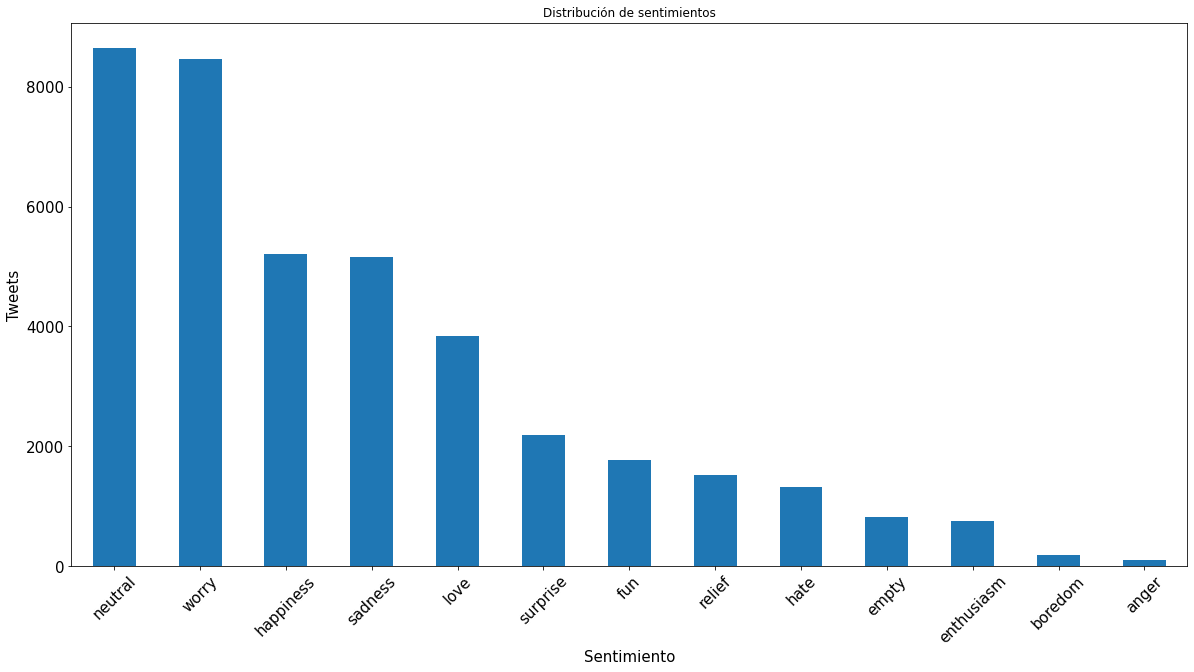

In [ ]:
import matplotlib.pyplot as plt

sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(20, 10))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=45, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

# Preprocesamiento de los datos

In [ ]:
# Realizar el preprocesamiento necesario

# Preparar el conjunto de datos

In [ ]:
print (df.head(1))
# eliminar columnas 'tweet_id' y 'author'
df.drop('tweet_id',axis=1,inplace=True)
df.drop('author',axis=1,inplace=True)
print (df.head(10))

# preprocesamiento. Eliminar campos NA y duplicados
print (len(df))
df = df.dropna().drop_duplicates()
print (len(df))

     tweet_id  ...                                            content
0  1956967341  ...  @tiffanylue i know  i was listenin to bad habi...

[1 rows x 4 columns]
    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...
5       worry  Re-pinging @ghostridah14: why didn't you go to...
6     sadness  I should be sleep, but im not! thinking about ...
7       worry               Hmmm. http://www.djhero.com/ is down
8     sadness            @charviray Charlene my love. I miss you
9     sadness         @kelcouch I'm sorry  at least it's Friday?
40000
39909


In [ ]:
# obtener diccionario de clases (Y)
sentiments = df['sentiment'].to_dict()

labels = list(set(sentiments.values()))
labels.sort()
print (labels)

label2idx = {label:i for i, label in enumerate(labels)}
idx2label = {label2idx[lbl] : lbl for lbl in label2idx}

print (f"label2idx= {label2idx}")
print (f"idx2label= {idx2label}")

print (f"Número de etiquetas (clases): {len(label2idx):,}")

['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']
label2idx= {'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}
idx2label= {0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fun', 5: 'happiness', 6: 'hate', 7: 'love', 8: 'neutral', 9: 'relief', 10: 'sadness', 11: 'surprise', 12: 'worry'}
Número de etiquetas (clases): 13


In [ ]:
# obtener diccionario de tweets (X)
tweets = df['content'].to_list()

tokens = set({token.lower() for tweet in tweets for token in tweet.split()})
tokens2idx = {'<<padding>>': 0} # <pad>, <PAD>, pad
tokens2idx.update({token : i+1 for i, token in enumerate(tokens)})
print (tokens2idx)
print (f"Longitud del vocabulario: {len(tokens2idx):,}")

max_tweet_length = 0
min_tweet_length = 100

X, Y = [], []

for index, row in df.iterrows():

  # reemplazar la etiqueta (sentiment) por su id en el conjunto de datos
  label = row['sentiment']
  # df.at[index, 'sentiment'] = label2idx[label]
  Y.append(label2idx[label])

  # obtener la longitud máxima y mínima del tweet
  if len(row['content'].split()) > max_tweet_length: max_tweet_length = len(row['content'].split())
  if len(row['content'].split()) < min_tweet_length: min_tweet_length = len(row['content'].split())
  
print (f"Tweet con la longitud máxima: {max_tweet_length:,}")
print (f"Tweet con la longitud mínima: {min_tweet_length:,}")

for index, row in df.iterrows():

  # reemplazar token en el tweet
  idx2token = [tokens2idx[token] for token in row['content'].lower().split()]

  # verificar si el tweet actual cuenta con la longitud máxima
  if len(idx2token) < max_tweet_length:
    n_padding = max_tweet_length - len(idx2token)
    idx2token += [tokens2idx['<<padding>>']] * n_padding # rellenar tweet

  # reemplazar el tweet (oración) con su lista de ids en el conjunto de datos
  # df.at[index, 'content'] = idx2token
  X.append(idx2token)

print (f"Longitud X: {len(X)}")
print (f"Longitud Y: {len(Y)}")

print ("=========================>",X[0])


{'<<padding>>': 0, 'hin': 1, 'response': 2, '@piraja': 3, 'hangover:': 4, 'th?c': 5, 'grr..': 6, 'terrorists': 7, 'delays': 8, 'casserole': 9, 'twitter!!': 10, 'skyping': 11, '@crusaderz4life': 12, "jaxx's": 13, 'following,': 14, 'yesterday...i': 15, '@mezzie1221': 16, '@itssamaramorgan': 17, '@fatsam33': 18, '@gfalcone': 19, 'skipped,': 20, 'nno': 21, '@cashstwit': 22, 'oooooooooo': 23, 'grandmother.': 24, 'smoking!!!!!!': 25, 'helmuts!': 26, 'embarrisong': 27, 'hoovering': 28, 'http://twitpic.com/4j9fb': 29, '@leilaanasazi:': 30, '@tashster': 31, '.n': 32, 'abrams': 33, '@stkulp': 34, 'yoyo': 35, 'weeds': 36, 'slapton': 37, 'resulted.': 38, 'layin': 39, "there.i've": 40, 'individual': 41, 'straits': 42, '10:24': 43, 'blk': 44, 'coming.': 45, '@jennifrayne': 46, 'bruno': 47, 'true;)&lt;3': 48, 'screwmyx': 49, 'goals': 50, 'decode': 51, 'head--&gt;ache.': 52, '@by_starla': 53, 'cache': 54, 'explode': 55, 'greetings!!': 56, 'hospital,': 57, 'oneself': 58, '&quot;problem&quot;': 59, 'cou

# Dividir el conjunto de datos en Train y Test

In [289]:
import numpy as np

# preparar el conjunto de datos
Y = np.array(Y, dtype="float32")[:, np.newaxis]

print (f"Shape Y:\t{Y.shape}")
print (Y)

X = np.array(X, dtype="float32")
print (f"\nShape X:\t{X.shape}")
print (X)


Shape Y:	(39909, 1)
[[ 2.]
 [10.]
 [10.]
 ...
 [ 7.]
 [ 5.]
 [ 7.]]

Shape X:	(39909, 34)
[[4.7800e+04 4.4962e+04 4.5883e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.9000e+01 4.0906e+04 6.2192e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.1830e+04 2.0895e+04 5.0325e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [3.2538e+04 3.4939e+04 2.5056e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.1272e+04 3.0564e+04 6.0431e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.3934e+04 4.4644e+04 6.8818e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [ ]:
# dividir el conjunto de entrenamiento en Train and Test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=0)

print(f"X_train.shape, Y_train.shape: {X_train.shape}, {Y_train.shape}")
print(f"X_test.shape, Y_test.shape: {X_test.shape}, {Y_test.shape}")

X_train.shape, Y_train.shape: (27936, 34), (27936, 1)
X_test.shape, Y_test.shape: (11973, 34), (11973, 1)


### TensorDataset y DataLoader

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# crear los tensores del conjunto de datos
train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
test = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

print (train[0])

# crear los cargadores del conjunto de datos
trainloader = DataLoader(train, batch_size=100, shuffle=True)
testloader = DataLoader(test, batch_size=100, shuffle=True)


(tensor([40744., 63239., 66881., 49779., 62889.,  7593., 29779., 22842., 73383.,
        58250., 19296., 25139.,  7593., 26008.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.]), tensor([12.]))


# Definir bibliotecas pytorch
Definimos la importación de la bibliotecas necesarias.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Definir el modelo líneal


In [ ]:
import math

class NNAnalisisSentimientos(nn.Module):
  
  def __init__(self, input_dim, hidden_dim, labels_dim):
    super(NNAnalisisSentimientos, self).__init__()

    # input_dim = máxima longitud de tweets  
    self.fc1 = nn.Linear(input_dim, hidden_dim)

    # definir una función no líneal de activación 1
    self.activation1 = nn.Sigmoid()

    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    # definir una función no líneal de activación 2
    self.activation2 = nn.Sigmoid()

    # Linear function 3 (readout): 500 --> 3
    self.fc3 = nn.Linear(hidden_dim, labels_dim)

  def forward(self, x):
    # propagación hacia adelante

    out = self.fc1(x)

    # Non-linearity 1
    out = self.activation1(out)

    # Linear function 2
    out = self.fc2(out)

    # Non-linearity 2
    out = self.activation2(out)

    # Linear function 3 (readout)
    out = self.fc3(out)

    out = F.log_softmax(out, dim=1)

    return out

# Entrenamiento de la `NNAnalisisSentimientos`

In [ ]:
# Instanciar el modelo
input_dim = max_tweet_length
hidden_dim = 500
labels_dim = len(label2idx)

model = NNAnalisisSentimientos(input_dim, hidden_dim, labels_dim)

model

NNAnalisisSentimientos(
  (fc1): Linear(in_features=34, out_features=500, bias=True)
  (activation1): Sigmoid()
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (activation2): Sigmoid()
  (fc3): Linear(in_features=500, out_features=13, bias=True)
)

In [ ]:
EPOCHS = 20
loss_plot, acc_plot = [], []


# definir la función de pérdida: Entropía Cruzada
loss_function = nn.CrossEntropyLoss()

# defnir el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.01)

# realizar el entrenamiento
for epoch in range(EPOCHS):
    total_loss, correct, total = 0, 0, 0
    for x, y in trainloader: 
        # establecer los gradientes a cero
        optimizer.zero_grad()

        # forward + loss + backward + optimise (update weights)
        # propagación hacia adelante
        y_hat = model(x)

        # convertir nuestro 
        target = torch.tensor(y.squeeze(1), dtype=torch.long).clone().detach()

        loss = loss_function(y_hat, target)
        
        # retropropagación
        loss.backward()

        optimizer.step()

        # registrar la pérdida o error (loss)
        total_loss += loss.item()
        
        y_hat = F.softmax(y_hat, dim=1)
        count = [1 for i, j in zip(torch.argmax(y_hat, dim=1), y) if i == j]
        correct += sum(count)
        total += len(y)
        acc = ((100.0 * correct) / total)

    
    total_loss /= len(y)

    print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {total_loss:4.2f}, Accuracy: {acc:2.2f}%")
    loss_plot.append(total_loss)
    acc_plot.append(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1/20, Loss: 16.77, Accuracy: 23.25%
Epoch: 2/20, Loss: 16.66, Accuracy: 23.92%
Epoch: 3/20, Loss: 16.64, Accuracy: 24.53%
Epoch: 4/20, Loss: 16.62, Accuracy: 24.72%
Epoch: 5/20, Loss: 16.62, Accuracy: 24.72%
Epoch: 6/20, Loss: 16.61, Accuracy: 24.80%
Epoch: 7/20, Loss: 16.61, Accuracy: 24.82%
Epoch: 8/20, Loss: 16.60, Accuracy: 24.83%
Epoch: 9/20, Loss: 16.60, Accuracy: 25.00%
Epoch: 10/20, Loss: 16.60, Accuracy: 24.90%
Epoch: 11/20, Loss: 16.59, Accuracy: 24.77%
Epoch: 12/20, Loss: 16.59, Accuracy: 24.96%
Epoch: 13/20, Loss: 16.59, Accuracy: 24.97%
Epoch: 14/20, Loss: 16.59, Accuracy: 24.88%
Epoch: 15/20, Loss: 16.59, Accuracy: 24.84%
Epoch: 16/20, Loss: 16.59, Accuracy: 24.98%
Epoch: 17/20, Loss: 16.59, Accuracy: 24.90%
Epoch: 18/20, Loss: 16.58, Accuracy: 24.84%
Epoch: 19/20, Loss: 16.58, Accuracy: 24.95%
Epoch: 20/20, Loss: 16.58, Accuracy: 25.03%


## Evaluar el modelo

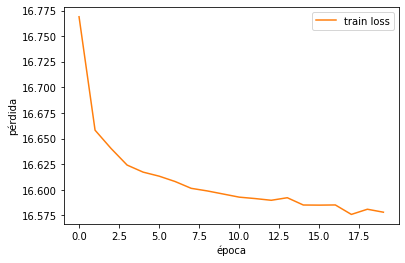

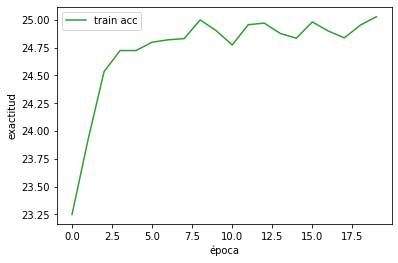

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Exactitud del Test: 25.30%
Exactitud del Test: 0.25%
{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        33
     boredom       0.00      0.00      0.00        54
       empty       0.00      0.00      0.00       248
  enthusiasm       0.00      0.00      0.00       228
         fun       0.00      0.00      0.00       533
   happiness       0.00      0.00      0.00      1558
        hate       0.00      0.00      0.00       397
        love       0.00      0.00      0.00      1140
     neutral       0.28      0.51      0.36      2585
      relief       0.00      0.00      0.00       457
     sadness       0.00      0.00      0.00      1548
    surprise       0.00      0.00      0.00       656
       worry       0.24      0.67      0.35      2536

    accuracy  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Visualizar la pérdida
plt.plot(loss_plot, 'tab:orange', label='train loss')
plt.legend(loc='best')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

# Visualizar la exactitud
plt.plot(acc_plot, 'tab:green', label='train acc')
plt.legend(loc='best')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

with torch.no_grad():
  model.eval()

  y_true, y_pred = [], []
  correct, total = 0, 0

  for x, y in testloader:
    y_hat = model(x)
    
    y = torch.tensor(y.squeeze(1), dtype=torch.long)
    y_hat = torch.argmax(y_hat, dim=1)

    y_true += list(y.cpu().numpy())
    y_pred += list(y_hat.cpu().numpy())
    
    count = [1 for i, j in zip(y_hat, y) if i == j]
    correct += sum(count)
    total += len(y)

print(f'Exactitud del Test: {(100.0 * correct) / total:2.2f}%')
print(f'Exactitud del Test: {accuracy_score(y_true, y_pred):2.2f}%')

print (label2idx)
print( classification_report(y_true, y_pred, target_names=list(label2idx.keys()) ) )